### Part I 

We will write code that performs logistic regression on linearly separable data, by learning weights through gradient descent of a cost function. This is a simple problem but it will allow us to understand better how a network with one hidden layer works in Part II. 

* The network required has an input layer of two neurons plus a bias and an output layer of one neuron. So the data matrix $\mathbf{X}$ has dimensions $(n_s,2)$, where $n_s$ is the number of samples. The target matrix $\mathbf{T}$, containing ones or zeros depending on the classification of the data, has dimensions $(n_s,1)$.
* On including the bias node (set to unity) we increase the column size of the data matrix by one and call this matrix $\mathbf{\tilde{X}}$.
* There is a weight matrix (just a vector in this case) $\mathbf{w}$ that has dimensions $(3,1)$.
* The activation function of the output neuron is a sigmoid function of its input $z$ such that $f(z)=1/(1+\exp(-z))$ where for one data point $z=\sum_i\tilde{x}_iw_i$ is a linear sum of the weighted inputs.
* The matrix of predictions of the network is therefore 
$$\mathbf{P}=f(\mathbf{\tilde{X}\mathbf{w}})$$
* The average cost function across the data is $$C=-\frac{1}{n_s}\sum_s\left[T_s\log(P_s)+(1-T_s)\log(1-P_s)\right]. $$

* As a general convention we will use upper-case letters when considering matricies of all data and lower-case letters for aone single data point.

In [1]:
# libraries required for plotting and maths
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Q1 Generate the data and the target

* Each data point comprises two numbers, both randomly distributed between $-1$ and $1$, which can be intepreted as an $(x, y)$ coordinate on a plane.
* If the point obeys $y>mx+\kappa$ we assign it a target value $t=1$, if not it has $t=0$.
* For $n_s$ samples the data can be summarised by two matricies. The first $\mathbf{X}$ has the coordinates and dimensions $(n_s,2)$ and the second $\mathbf{T}$ has the targets and has dimensions $(n_s,1)$.
* Generate these matricies and plot the points in green that have $t=1$ and red that have $t=0$. Draw the dividing line given by $y=mx+\kappa$.
* Suggested parameters are $n_s=50$, $m=1$ and $\kappa=0.1$

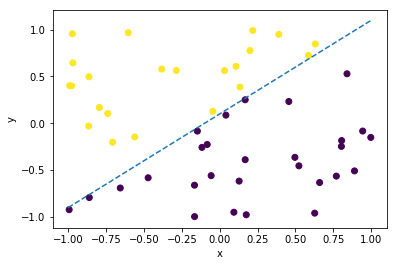

In [2]:
ns = 50
m = 1.0
κ = 0.1

X = 2*(np.random.rand(ns, 2)-0.5)
T = 1.0*(X[:,1]>(m*X[:,0]+κ))
T = T[:,None]

# Class seperating line
x = np.linspace(-1,1,100)
y = m*x + κ

# Plot
plt.figure()
plt.scatter(X[:,0],X[:,1],c=T)
plt.plot(x,y,'--')
plt.xlabel('x')
plt.ylabel('y');

### Q2 Write a function that calculates a prediction and cost for a given set of weights
* We now include a bias so we define a new matrix $\tilde{\mathbf{X}}$ that includes a column of ones. This matrix has dimensions $(n_s,3)$.
* The weight matrix $w$ has dimensions ($3,1)$ and stores the information learned about the data.
* The prediction matrix $\mathbf{P}$ has the same dimensions as $\mathbf{T}$ and is given by $\mathbf{P}=f(\tilde{\mathbf{X}}\mathbf{w})$ where $f(z)=1/(1+e^{-z})$.
* The cost function is $$C=-\frac{1}{n_s}\sum_s\left[T_s\log(P_s)+(1-T_s)\log(1-P_s)\right]$$
* Write a function that takes $\tilde{\mathbf{X}}$ and a weight matrix $\mathbf{w}$ as inputs and outputs the prediction matrix $\mathbf{P}$ and cost $C$.

In [10]:
def predict(Xb, w):
    assert Xb.shape[1]==w.shape[0]
    ns=Xb.shape[0]
    Z=np.matmul(Xb,w)
    P=1./(1+np.exp(-Z))
    return P

def cost(P, T):
    C = -np.sum(T*np.log(P)+(1-T)*np.log(1-P))/ns
    return C

### Q3 Write a function that calculates the weight gradients
We first do a little theory to calculate the form of the cost gradient with respect to changes in the weight. For simplicity we will consider a single data point first.
* Let the cost of one sample be
$$c=-[t\log(p)+(1-t)\log(1-p)].$$ 
Show that 
$$ \frac{dc}{dp}=\frac{p-t}{p(1-p)},~~~\frac{dp}{dz}=p(1-p) ~~~\mbox{ and } \frac{dz}{dw_i}=\tilde{x}_i$$
* Hence show that $$\frac{dc}{dw_i}=\frac{dp}{dz}\frac{dz}{dw_i}=\tilde{x}_i(p-t) ~~\mbox{ and }~~\frac{dC}{dw_i}=\frac{1}{n_s}\sum_s\tilde{X}_{si}(P_{si}-T_{si}) ~~\mbox{for the entire data set}.$$ 
* In matrix form we therefore have $$\frac{dC}{d\mathbf{w}}=\frac{1}{n_s}\tilde{X}'\Delta^p~~~\mbox{ where }~~~\Delta^p=\mathbf{P}-\mathbf{T} ~~~\mbox{ or }~~~\delta^p=p-t~~~\mbox{for one data point}$$ 
* Write a function that takes in $\mathbf{\tilde{X}}$, $\mathbf{w}$, $\mathbf{P}$ and $\mathbf{T}$ and outputs $dC/d\mathbf{w}$ as a matrix  of dimension $(1,3)$

In [11]:
def gradient(Xb, P, T):
    assert P.shape==T.shape
    ns=Xb.shape[0]
    Δp=P-T
    dCdw=np.matmul(Xb.T, Δp)/ns
    return dCdw

### Q4 Gradient descent for the weights
* Write a loop that does $n_i$ gradient-descent iterations, where for each one the weight matrix is updated using the rule $$ \mathbf{w}_\mathrm{new}=\mathbf{w}_\mathrm{old}-\alpha\frac{dC}{d\mathbf{w}} $$ where $\alpha$ is a positive learning rate that you can choose.
* Plot a graph of the cost $C$ as a function of the iteration steps and check that it is monotonically decreasing.
* When the input $z$ into the output node vanishes then $p=0.5$ which defines the separation line. The criterion $z=0$ corresponds to $xw_1+yw_2+w_3=0$ and defines a line separating the classification in the $x-y$ plane. Plot the line for your weights on the graph of data points and compare it to the true separting line used to generate the data labels.

In [19]:
def GradDescent(X, T, α, n_iter):
    
    n_samples=X.shape[0]
    nx=X.shape[1]
    Xb=np.hstack([X,np.ones((n_samples,1))])
    w=np.random.randn(nx+1,1)
    
    C_i=np.zeros((n_iter,1))
    
    for i in range(n_iter):
        P = predict(Xb, w)
        C_i[i] = cost(P, T)
        dCdw = gradient(Xb, P, T)
        w=w-α*dCdw
        
    return (w, C_i)

In [13]:
w, Ci = GradDescent(X, T, 0.05, 1000)

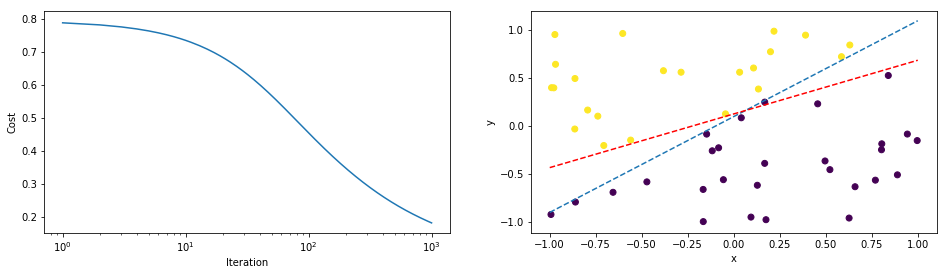

In [18]:
y2 = -x*w[0]/w[1]-w[2]/w[1]

plt.figure(figsize=(16,9))
plt.subplot(221)
plt.semilogx(np.arange(Ci.shape[0]), Ci)
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.subplot(222)
plt.scatter(X[:,0],X[:,1],c=T)
plt.plot(x,y,'--')
plt.plot(x,y2,'r--')
plt.xlabel('x')
plt.ylabel('y');